In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load data
input_data = np.load('../../WaveSuite/regularWave_pcs_U_data_0_to_131.npy')
output_data = np.load('../../WaveSuite/regularWave_pcs_nut_data_0_to_131.npy')
print(input_data.shape)

# Data is in float32 format
input_data = input_data.astype(np.float32)
output_data = output_data.astype(np.float32)

min_input = np.min(input_data)
max_input = np.max(input_data)
min_output = np.min(output_data)
max_output = np.max(output_data)
min = 0
max = +1

def scaler(x, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xScaled = scale * x + min - xmin * scale
    return xScaled

input_scaled = scaler(input_data, min_input, max_input, min, max)
output_scaled = scaler(output_data, min_output, max_output, min, max)

# Train/Test split
n_samples = 131
indices = np.arange(n_samples)
input_train, input_test, output_train, output_test, indices_train, indices_test = train_test_split(input_scaled, output_scaled, indices, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(torch.from_numpy(input_train), torch.from_numpy(output_train))
test_dataset = TensorDataset(torch.from_numpy(input_test), torch.from_numpy(output_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the autoencoder
class AAE(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(AAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(131, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(128, 16)

        # Decoder
        self.fc4 = nn.Linear(16, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.fc5 = nn.Linear(128, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout5 = nn.Dropout(dropout_rate)
        
        self.fc6 = nn.Linear(512, 131)

    def encode(self, x):
        h1 = F.leaky_relu(self.bn1(self.fc1(x)))
        h1 = self.dropout1(h1)
        
        h2 = F.leaky_relu(self.bn2(self.fc2(h1)))
        h2 = self.dropout2(h2)
        
        return self.fc3(h2)

    def decode(self, z):
        h3 = F.leaky_relu(self.bn4(self.fc4(z)))
        h3 = self.dropout4(h3)
        
        h4 = F.leaky_relu(self.bn5(self.fc5(h3)))
        h4 = self.dropout5(h4)
        
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        z = self.encode(x.view(-1, 131))
        return self.decode(z), z

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(16, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(512, 1)

    def forward(self, z):
        h1 = F.relu(self.bn1(self.fc1(z)))
        h1 = self.dropout1(h1)
        
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h2 = self.dropout2(h2)
        
        return torch.sigmoid(self.fc3(h2))

# Define loss functions
def autoencoder_loss_function(recon_x, target):
    return F.mse_loss(recon_x, target.view(-1, 131), reduction='sum')

def discriminator_loss_function(real_outputs, fake_outputs):
    real_loss = F.binary_cross_entropy(real_outputs, torch.ones_like(real_outputs))
    fake_loss = F.binary_cross_entropy(fake_outputs, torch.zeros_like(fake_outputs))
    return real_loss + fake_loss

# Initialize models and optimizers
autoencoder = AAE().cuda()
discriminator = Discriminator().cuda()
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

# Initialize list to store losses
train_losses = []
test_losses = []

# Training loop
def train(epoch):
    autoencoder.train()
    discriminator.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()  # Move data to GPU
        target = target.cuda()  # Move target to GPU

        # Autoencoder step
        autoencoder_optimizer.zero_grad()
        recon_data, z_fake = autoencoder(data)
        recon_loss = autoencoder_loss_function(recon_data, target)
        recon_loss.backward()
        autoencoder_optimizer.step()

        # Discriminator step
        discriminator_optimizer.zero_grad()
        z_real = torch.randn(z_fake.size()).cuda()
        real_outputs = discriminator(z_real)
        fake_outputs = discriminator(z_fake.detach())
        disc_loss = discriminator_loss_function(real_outputs, fake_outputs)
        disc_loss.backward()
        discriminator_optimizer.step()

        train_loss += recon_loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    if epoch % 100 == 0:
        print('====> Epoch: {} Average training loss: {:.4f}'.format(epoch, avg_train_loss))


# Test loop
def test(epoch):
    autoencoder.eval()
    discriminator.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.cuda()  # Move data to GPU
            target = target.cuda()  # Move target to GPU
            recon_data, z_fake = autoencoder(data)
            recon_loss = autoencoder_loss_function(recon_data, target)
            test_loss += recon_loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    if epoch % 100 == 0:
        print('====> Test set loss: {:.4f}'.format(avg_test_loss))

# Run training and test loops
num_epochs = 50000
for epoch in range(0, num_epochs + 1):
    train(epoch)
    test(epoch)


(131, 131)
====> Epoch: 0 Average training loss: 11.0649
====> Test set loss: 9.2926
====> Epoch: 100 Average training loss: 0.9296
====> Test set loss: 0.8390
====> Epoch: 200 Average training loss: 0.6037
====> Test set loss: 0.9111
====> Epoch: 300 Average training loss: 0.4557
====> Test set loss: 0.9757
====> Epoch: 400 Average training loss: 0.3638
====> Test set loss: 0.9190
====> Epoch: 500 Average training loss: 0.2833
====> Test set loss: 0.9228
====> Epoch: 600 Average training loss: 0.2070
====> Test set loss: 0.8274
====> Epoch: 700 Average training loss: 0.2390
====> Test set loss: 0.8162
====> Epoch: 800 Average training loss: 0.1868
====> Test set loss: 0.8059
====> Epoch: 900 Average training loss: 0.1603
====> Test set loss: 0.6886
====> Epoch: 1000 Average training loss: 0.1439
====> Test set loss: 0.6362
====> Epoch: 1100 Average training loss: 0.1236
====> Test set loss: 0.4831
====> Epoch: 1200 Average training loss: 0.1032
====> Test set loss: 0.5032
====> Epoch:

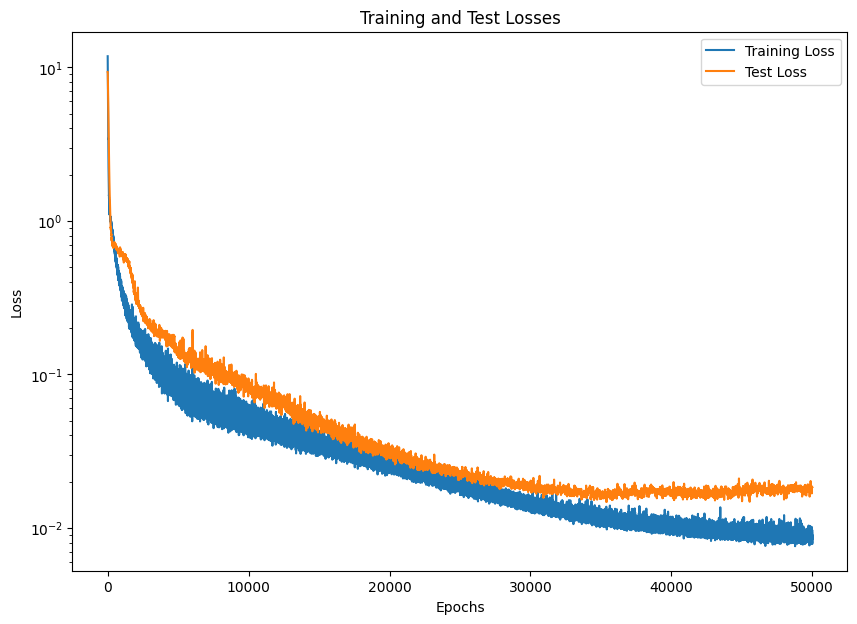

In [39]:
# Plot training and test losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

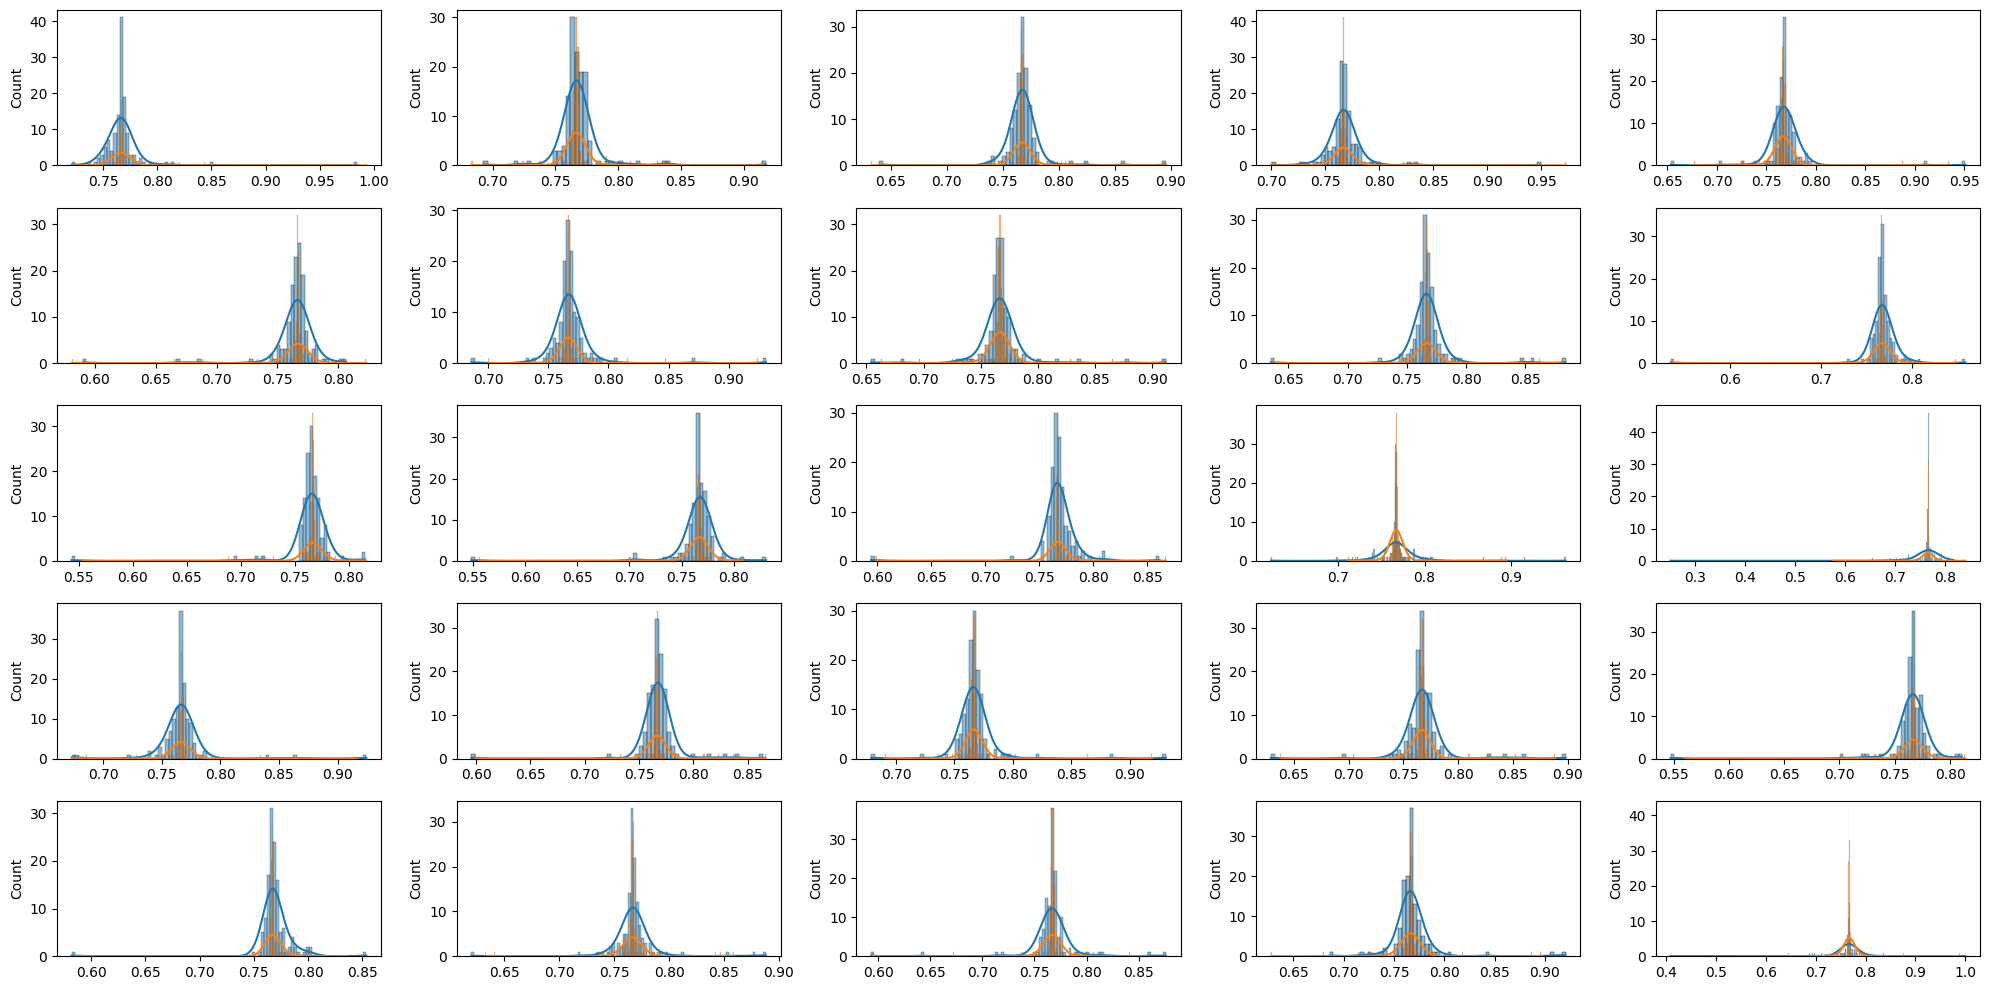

In [40]:
import seaborn as sns
# Set model to evaluation mode
autoencoder.eval()

# Lists to store target and predicted values
targets = []
predictions = []

# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        recon_batch, _ = autoencoder(data)
        targets.append(target.cpu().numpy())
        predictions.append(recon_batch.cpu().numpy())

# Concatenate targets and predictions into numpy arrays
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)

fig = plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    sns.histplot(targets[i, :], kde=True)
    sns.histplot(predictions[i, :], kde=True)
plt.tight_layout()

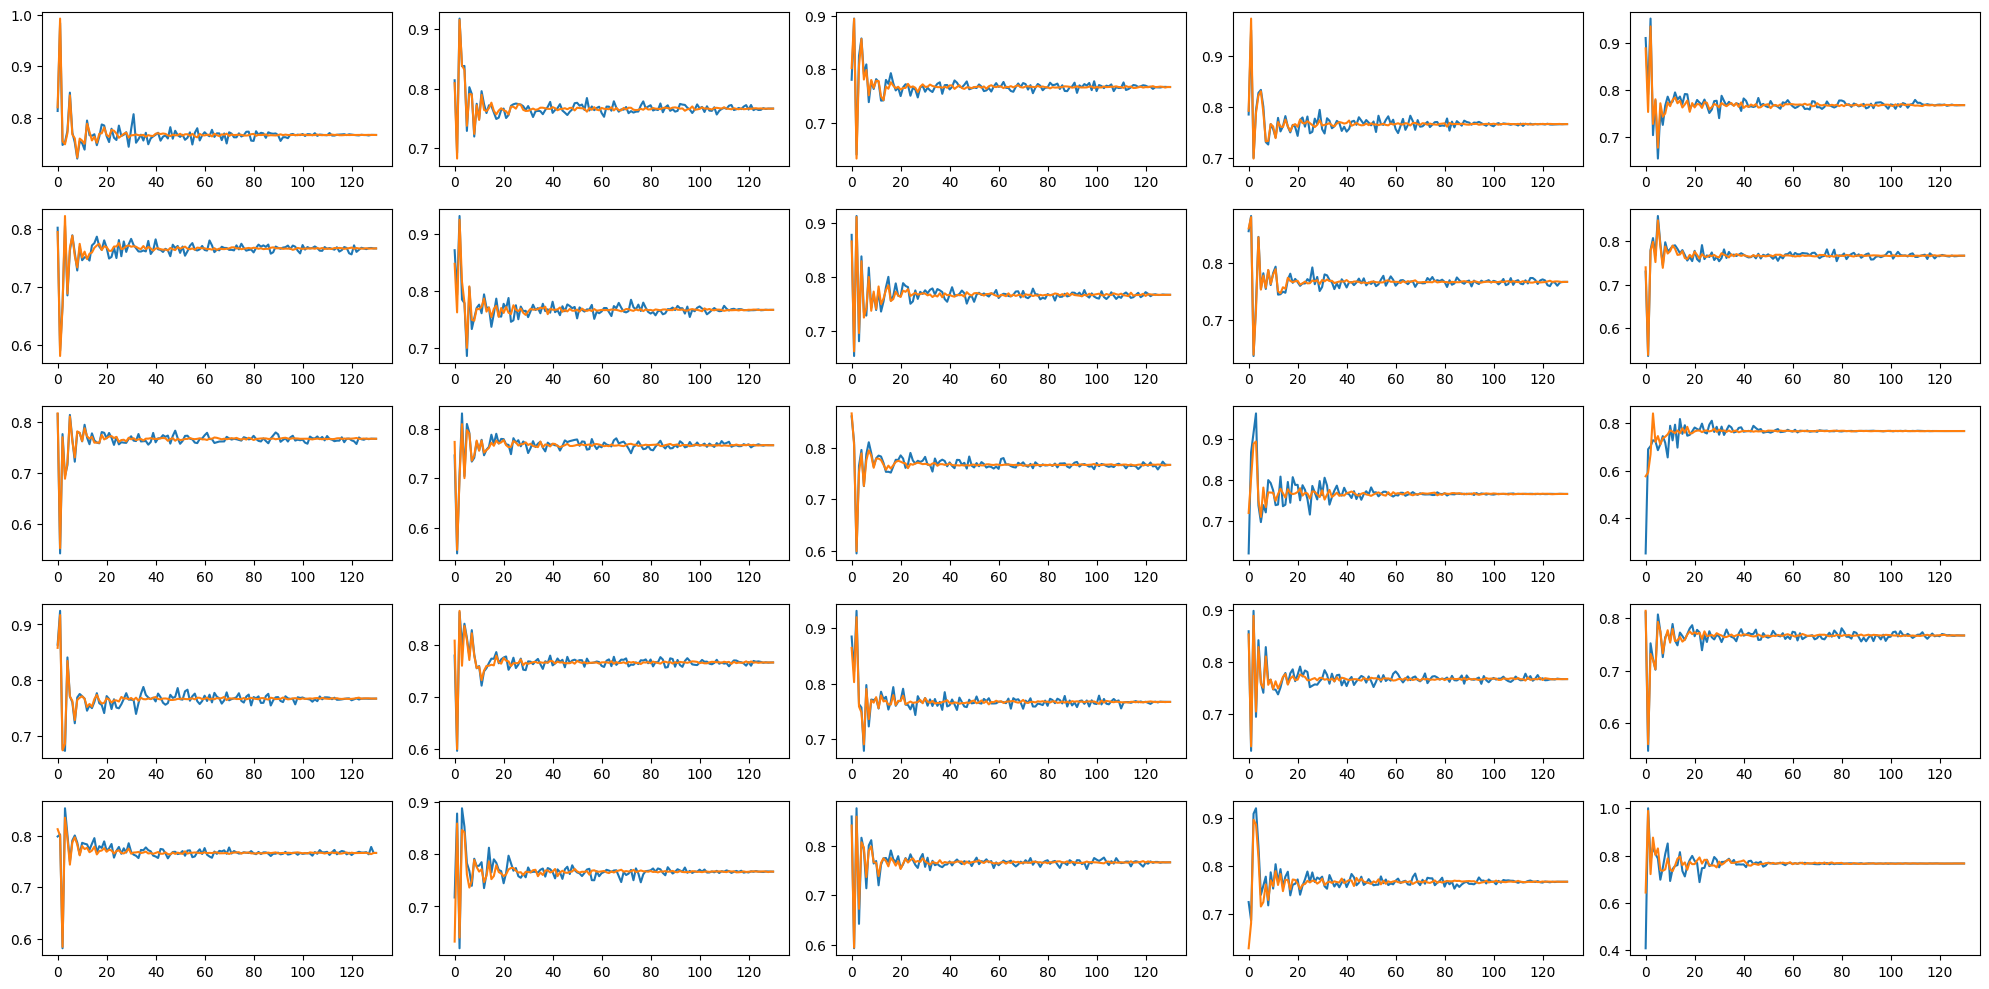

In [42]:
fig = plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(targets[i, :])
    plt.plot(predictions[i, :])
plt.tight_layout()

In [43]:
'''Reverse back to physical space and compare'''
def inverseScaler(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv

output_eofs = np.load('../../WaveSuite/regularWave_eofs_nut_data_0_to_131.npy')
output_mean = np.load('../../WaveSuite/regularWave_mean_nut_data_0_to_131.npy')
output_std = np.load('../../WaveSuite/regularWave_std_nut_data_0_to_131.npy')

predictions = inverseScaler(predictions, min_output, max_output, 0, 1)
targets = inverseScaler(targets, min_output, max_output, 0, 1)

y_pred = np.matmul(predictions, output_eofs)*output_std + output_mean
np.save('./y_pred_AAE.npy', y_pred)
test_data = np.matmul(targets, output_eofs)*output_std + output_mean
np.save('./test_data.npy', test_data)
print(np.mean(y_pred))
print(np.mean(test_data))

error = test_data - y_pred
np.save('./error_AAE.npy', error)

0.000297407892070378
0.0002917257976251685


In [44]:
print(np.max(error))
print(np.max(targets))

0.00535074346960997
182.57263
